# Import and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy import special
import math
import time as toc
import import_ipynb
import os


try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from SpatialTemporal_Correlation_and_Convolution import STcorrelate
from SpatialTemporal_Correlation_and_Convolution import ST_STA
from SpatialTemporal_Correlation_and_Convolution import STconvolve
from Spike_Generation import NL
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\MB_FB_model')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\MB_FB_model')
%matplotlib inline

importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [2]:
def Gaussian_filter_1d(x,s):
    return(np.exp(-(x/s)**2/2))/s/np.sqrt(np.pi*2)

In [3]:
def Retina_Mechine_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = max(sigma_dict.values())*5
    xx = np.arange(-klen,klen,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])

    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
#         plt.plot(T,Ky)
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]-1):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry = np.convolve(output[i,:],KH,'same')*dx  # feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        rz = np.convolve(zts[i,:],KH,'same')*dx     # feedback from horizontal cell (z convoluted with horitonatl cell receptive field KH)

        dyj =(-para_dict['alpha']*output[i,:]+para_dict['k']*(rs-para_dict['phi']*rz))
        dzj =(-para_dict['beta']*zts[i,:]+para_dict['g']*output[i,:])
        output[i+1,:] = (output[i,:]+dyj*dt)*loc_dict['C']
        zts[i+1,:] = (zts[i,:]+dzj*dt)*loc_dict['H']
        
        maxpos = np.argmax(output[i+1,:])
        rpeak[i+1]= maxpos*dx
    return output, zts, rpeak

def FB_FF_1l_1D(stimulus, sigma_dict, para_dict, dx, dt, loc_dict = 1):
    if loc_dict == 1:
        loc_dict = {}
        loc_dict['C'] = 1
        loc_dict['H'] = 1
        
    klen = min(max(sigma_dict.values())*3, int(stimulus.shape[1]/2/dx))
    xx = np.arange(-klen,klen+dx,dx)
    KC = Gaussian_filter_1d(xx,sigma_dict['C'])
    KH = Gaussian_filter_1d(xx,sigma_dict['H'])
    KB = Gaussian_filter_1d(xx,sigma_dict['B'])
#     plt.plot(KC)
#     plt.plot(KH)
#     plt.plot(KB)
#     plt.plot(KC-KH)
    
    output = np.zeros_like(stimulus)#y output
    zts = np.zeros_like(stimulus)#horizontal
    yts = np.zeros_like(stimulus)#horizontal
    wts = np.zeros_like(stimulus)#horizontal
    sstm = np.zeros_like(stimulus)
    rpeak1 = np.zeros(np.shape(stimulus)[0])
    rpeak2 = np.zeros(np.shape(stimulus)[0])
    rinvertpeak2 = np.zeros(np.shape(stimulus)[0])
    
    if 'tau_y' in sigma_dict.keys():
        T = np.arange(0,int(sigma_dict['tau_y']/dt*8))*dt
        Ky=T/sigma_dict['tau_y'] /sigma_dict['tau_y'] *np.exp(-T/sigma_dict['tau_y'])
        for j in range(np.shape(stimulus)[1]):
            for i in range(len(Ky)-1):
                for ii in range(i+1):
                    sstm[i,j] += stimulus[ii,j]*Ky[i-ii]*dt
            sx = np.convolve(stimulus[:,j],Ky,'valid')*dt
            sstm[len(Ky)-1:,j] = sx.copy()
    else:
        sstm = stimulus.copy()

    for i in range(np.shape(stimulus)[0]):
        s = sstm[i,:]
        rs = np.convolve(s,KC,'same')*dx
        ry2z = np.convolve(yts[i-1,:],KH,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dyj =(-para_dict['alpha']*yts[i-1,:]+para_dict['k']*(rs-para_dict['phi']*zts[i-1,:]))*dt
        dzj =(-para_dict['beta']*zts[i-1,:]+para_dict['g']*ry2z)*dt
                
        yts[i,:] = (yts[i-1,:]+dyj)*loc_dict['C']
        zts[i,:] = (zts[i-1,:]+dzj)*loc_dict['H']
        ry2w = np.convolve(yts[i-1,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
        dwj =(-para_dict['gramma']*wts[i-2,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i-1,:]))*dt

        wts[i-1,:] = (wts[i-2,:]+dwj)
        maxpos1 = np.argmax(yts[i,:])
        rpeak1[i]= maxpos1*dx
        maxpos2 = np.argmax(wts[i-1,:])
        rpeak2[i-1]= maxpos2*dx
        maxipos2 = np.argmin(wts[i-1,:])
        rinvertpeak2[i-1]= maxipos2*dx
    
    ry2w = np.convolve(yts[i,:],KB,'same')*dx# feedback from horizontal cell (y convoluted with horitonatl cell receptive field KH)
    dwj =(-para_dict['gramma']*wts[i-1,:]+para_dict['p']*((1-para_dict['psy'])*ry2w-para_dict['psy']*zts[i,:]))*dt
    wts[i,:] = (wts[i-1,:]+dwj)
    maxpos2 = np.argmax(wts[i,:])
    rpeak2[i]= maxpos2*dx
    maxipos2 = np.argmin(wts[i,:])
    rinvertpeak2[i]= maxipos2*dx
    return wts, zts, yts, rpeak1, rpeak2, rinvertpeak2

In [4]:
def Ay(para_dict, sigma_dict, x, n = 1000):
    alpha = para_dict['alpha']
    beta = para_dict['beta']
    k = para_dict['k']
    phi = para_dict['phi']
    g = para_dict['g']
    sigma_h = sigma_dict['H']
    sigma_c = sigma_dict['C']
    ans =  0
    for i in range(n+1):
        ans += k/alpha/np.sqrt(np.pi)*(-k*g/alpha/beta)**i/np.sqrt(sigma_c**2+i*sigma_h**2)*np.exp(-x**2/(sigma_c**2+i*sigma_h**2))
    return ans

# Setting parameters

## CKC's parameters

In [65]:
filename = 'CKC STkernels-good parameters'

NGD_sigma_dict = dict()
NGD_sigma_dict['H'] = 1
NGD_sigma_dict['C'] = NGD_sigma_dict['H']*0.1 # RF size of cone cell
dx = NGD_sigma_dict['H']/40.

dt=0.01  #large dt will cause  overflow
NGD_sigma_dict['tau_y'] = 0.02
#Width setting
xlen = 50*NGD_sigma_dict['H'] #spatial extend of simulation
Dynamical_range = 6*NGD_sigma_dict['H']/dx #188-16 pixels
hw = 3*Dynamical_range*dx/22 #half bar width  #8 pixels
tempx = np.arange(0,xlen/dx+1)*dx

NGD_para_dict = {}
NGD_para_dict['alpha'] = 30. 
NGD_para_dict['beta'] = 1.2
NGD_para_dict['k'] = 20. #not important if there is no adaption
NGD_para_dict['phi'] = 1.
NGD_para_dict['g'] = 30. #but k*g are important


FBFF_sigma_dict = NGD_sigma_dict.copy()
FBFF_para_dict = NGD_para_dict.copy()
FBFF_para_dict['gramma'] = 100.
FBFF_para_dict['p'] = 100. # not important if there is no adaption
FBFF_para_dict['psy'] = 0.1

FBFF_sigma_dict['B'] = FBFF_sigma_dict['H']*0.5



# para_dict['g']*para_dict['k']*para_dict['phi']/para_dict['alpha']/para_dict['beta']

# TK

## from white noise

In [6]:
# wnmean = 10
# wnstd = 2
# n_twn = np.random.randn(10000)
# n_twn = (n_twn - np.mean(n_twn))/np.std(n_twn)
# homo_cSTA = np.matmul((n_twn*wnstd + wnmean)[:, np.newaxis], np.ones(int(xlen/dx)+1)[np.newaxis, :])
# wts, zts, yts, _, _, _ = FB_FF_1l_1D(homo_cSTA, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
# csta_output = wts
# csta_output_y = yts
# # z1ts, z2ts, y1ts, y2ts, _ = FF_FB_2l_1D(homo_cSTA, FFFB_sigma_dict, FFFB_para_dict, dx, dt)
# # csta_output = y2ts

In [7]:
# output = NL(yts[:,int(xlen/dx/2)], 0)
# TK = np.correlate(output, n_twn, 'same')/ np.correlate(output, np.ones_like(n_twn), 'same')*dt
# TK = TK[(round(len(TK)/2)+int(0.5/dt)):(round(len(TK)/2)-1):-1]
# TKtaxis = np.arange(-len(TK)+1,1)*dt
# plt.plot(TKtaxis,TK/max(TK))

# output = wts[:,int(xlen/dx/2)]
# TK = np.correlate(output, n_twn, 'same')/ np.correlate(output, np.ones_like(n_twn), 'same')*dt
# TK = TK[(round(len(TK)/2)+int(0.5/dt)):(round(len(TK)/2)-1):-1]
# TKtaxis = np.arange(-len(TK)+1,1)*dt
# plt.plot(TKtaxis,TK/max(TK))

## from delta input

In [8]:
nstep = int(1.6/dt)
TDelta_input = np.zeros([nstep, int(xlen/dx)+1])
TDelta_input[0,:] = 2
TDelta_output_w, zts, TDelta_output_y, _, _, _ = FB_FF_1l_1D(TDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)
# Delta_output =Delta_output_w

Text(0.5, 1.0, 'temporal filter')

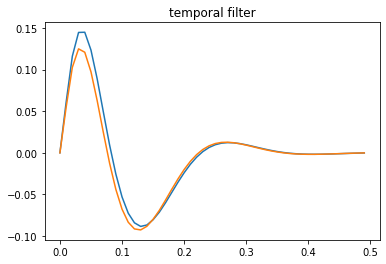

In [13]:
TKtaxis = np.arange(0,0.5,dt)
plt.plot(TKtaxis, TDelta_output_y[:len(TKtaxis),int(xlen/dx/2)])
tempTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]
plt.plot(TKtaxis, tempTK)
plt.title('temporal filter')

In [88]:
delTK = TDelta_output_w[:len(TKtaxis),int(xlen/dx/2)]/(int(xlen/dx)+1)

# SK

## from delta input

In [85]:
nstep = int(1.6/dt)
SDelta_input = np.zeros([nstep, int(xlen/dx)+1])
SDelta_input[:, int(xlen/dx/2)] = 2
SDelta_output_w, zts, SDelta_output_y, _, _, _ = FB_FF_1l_1D(SDelta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

Text(0.5, 1.0, 'spatial filter')

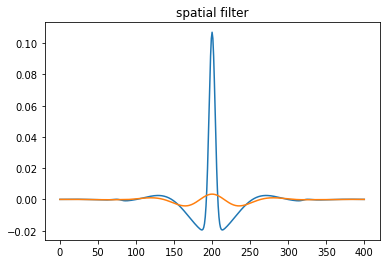

In [86]:
plt.plot(SDelta_output_y[-1,int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.plot(SDelta_output_w[-1,int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.title('spatial filter')

In [87]:
delSK = SDelta_output_w[-1,int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1]/nstep

# from white noise

In [45]:
# nstep = 5000
# wnstd = 0.1
# wnmean = 1
# n_swn = np.random.randn(int(xlen/dx)+1)
# n_swn = (n_swn - np.mean(n_swn))/np.std(n_swn)
# ScSTA = n_swn[np.newaxis, :]*np.ones(nstep)[:, np.newaxis]*wnstd + wnmean
# wts, zts, yts, _, _, _ = FB_FF_1l_1D(ScSTA, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

In [47]:
# op = np.sum(wts, axis =0)/nstep
# SK = np.correlate(op, n_swn, 'same')/ np.correlate(op, np.ones_like(n_swn), 'same')*dt
# plt.plot(SK)

# Spatio-Temporal Kernel

## from delta input

In [19]:
nstep = int(1.6/dt)
Delta_input = np.zeros([nstep, int(xlen/dx)+1])
Delta_input[0, int(xlen/dx/2)] = 2
Delta_output_w, zts, Delta_output_y, _, _, _ = FB_FF_1l_1D(Delta_input, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

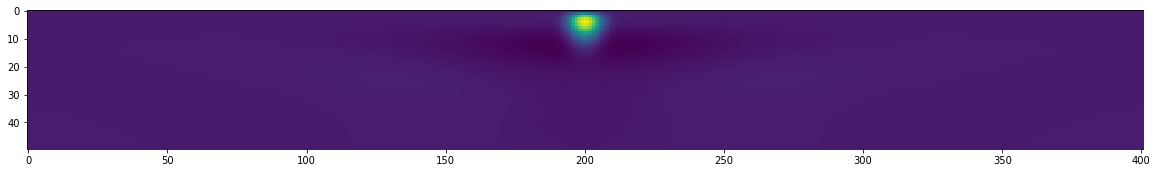

In [24]:
plt.imshow(Delta_output_y[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.gcf().set_size_inches(20, 5)

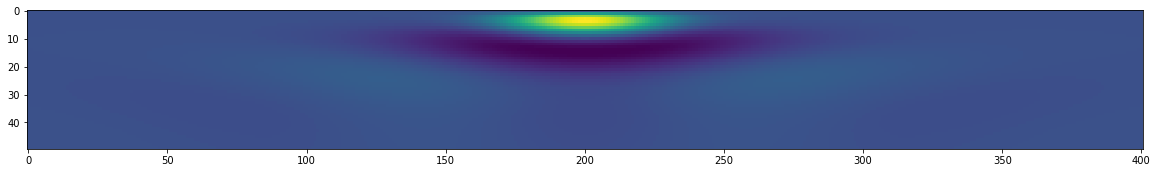

In [34]:
plt.imshow(Delta_output_w[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1])
plt.gcf().set_size_inches(20, 5)

In [48]:
delSTK = Delta_output_w[:len(TKtaxis),int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1]

## from white noise

In [66]:
# nstep = 5000
# wnstd = 0.1
# wnmean = 1
# n_stwn = np.random.randn(nstep, int(xlen/dx)+1)
# n_stwn = (n_stwn - np.mean(n_stwn))/np.std(n_stwn)
# ST_cSTA = n_stwn*wnstd + wnmean
# wts, zts, yts, _, _, _ = FB_FF_1l_1D(ST_cSTA, FBFF_sigma_dict, FBFF_para_dict, dx, dt)

In [67]:
# stcsta_output = wts[:,int(FBFF_sigma_dict['B']/dx):int(-FBFF_sigma_dict['B']/dx)]
# stcsta_output_y = yts[:,int(FBFF_sigma_dict['B']/dx):int(-FBFF_sigma_dict['B']/dx)]

In [29]:
# tic = toc.time()
# time_window = [-0.5,0.1]
# step = np.round(np.arange(time_window[0],time_window[1],dt)/dt).astype(int)
# # test2, (time_axis, space_axis) = STcorrelate(ST_cSTA, stcsta_output,step,dx,dt)
# test4, (time_axis, space_axis) = ST_STA(n_stwn, stcsta_output,step,dx,dt)
# toc.time()-tic

227.07901167869568

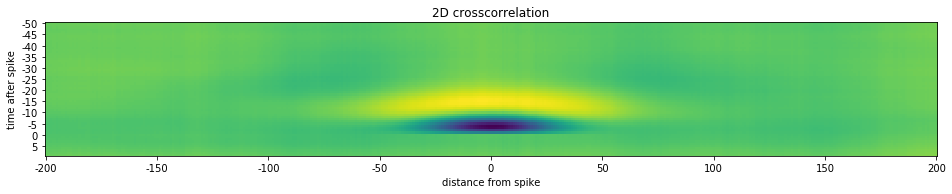

In [30]:
# space_window = np.arange(-int(xlen/dx/10),1+int(xlen/dx/10))
# fig, ax2 = plt.subplots(nrows=1, ncols=1)
# ax2.imshow((test4)[:,space_window+int(xlen/dx/2)])
# ax2.set_yticks(np.arange(0,len(step),5))
# ax2.set_yticklabels(step[np.arange(0,len(step),5)])
# ax2.set_ylabel('time after spike')
# ax2.set_xticks(np.arange(0,len(space_window),50))
# ax2.set_xticklabels(space_window[np.arange(0,len(space_window),50)])
# ax2.set_xlabel('distance from spike')
# ax2.set_title('2D crosscorrelation')
# fig = plt.gcf()
# fig.set_size_inches(16, 10)

choose center cell and a certain time before spike

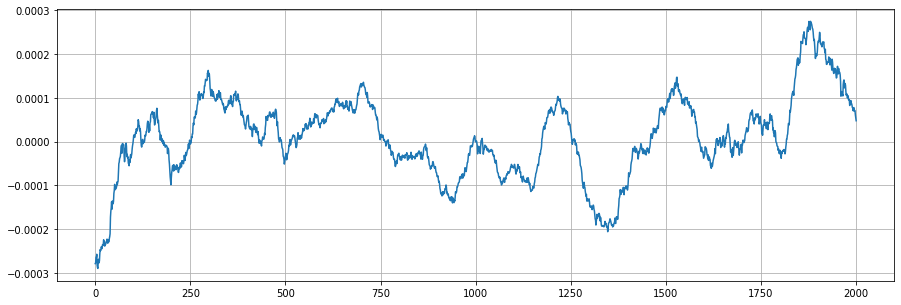

In [60]:
# tbs_i = 50
# plt.plot(test4[tbs_i, :])
# plt.grid()
# fig = plt.gcf()
# fig.set_size_inches(15, 5)

In [61]:
# # ST_kernel2 = []
# # for i in np.arange(0,np.argmin(np.abs(step))):
# #     ST_kernel2.append(test2[i,:]+np.flip(test2[i,:]))
# # ST_kernel2 = np.flipud(np.array(ST_kernel2)/2)

# ST_kernel4 = []
# for i in np.arange(0,np.argmin(np.abs(step))+1):
#     ST_kernel4.append(test4[i,:]+np.flip(test4[i,:]))
# ST_kernel4 = np.flipud(np.array(ST_kernel4)/2)

# new_time_axis = np.flip(time_axis.copy()[:np.argmin(np.abs(step))])



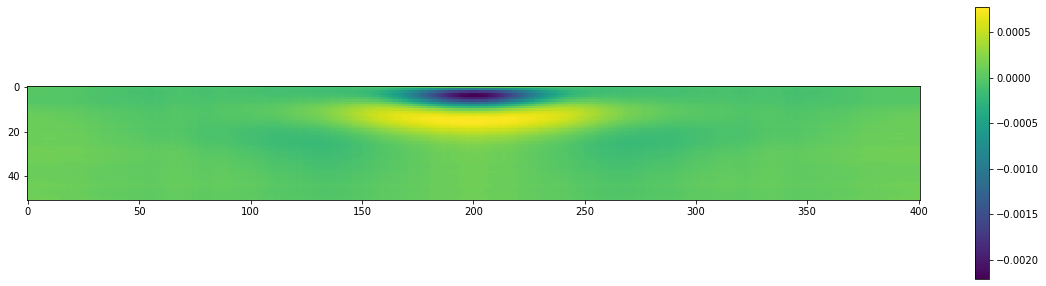

In [62]:
# ST_kernel = ST_kernel4[:, space_window+int(xlen/dx/2)]
# plt.imshow(ST_kernel)
# plt.colorbar()
# fig = plt.gcf()
# fig.set_size_inches(20, 5)

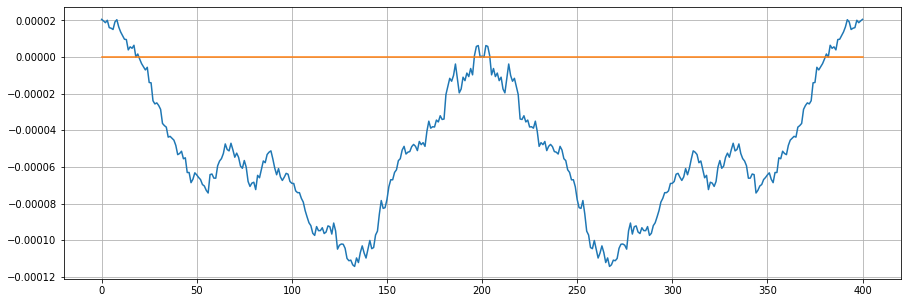

In [63]:
# tbs_i = 0
# plt.plot(ST_kernel[tbs_i, :])
# plt.plot(-delSTK[tbs_i, :])
# plt.grid()
# fig = plt.gcf()
# fig.set_size_inches(15, 5)

# Separate by Integration

In [89]:
iTk = np.sum(delSTK, axis = 1)*dx
iSk = np.sum(delSTK, axis = 0)*dt

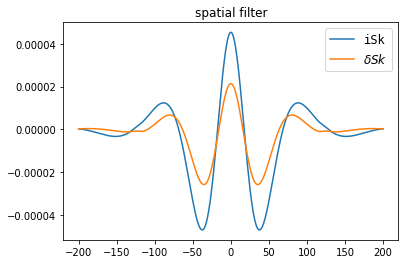

In [90]:
plt.plot(space_window, iSk)
plt.plot(space_window, delSK)
plt.title('spatial filter')

plt.legend( ('iSk', r'$\delta Sk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

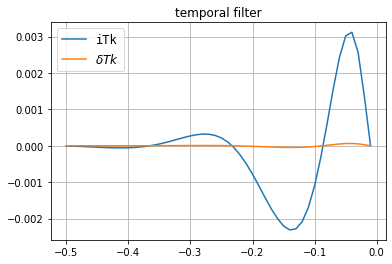

In [91]:
plt.plot(new_time_axis, iTk)
plt.plot(new_time_axis, delTK)
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', r'$\delta Tk$'), loc='best', prop={'size': 'large', 'family': 'monospace'})

In [22]:
sSTk = iSk[np.newaxis,:]*iTk[:, np.newaxis]
ssSTk = cut_Delta_output[np.newaxis,:]*np.flipud(n_TK[:len(iTk), np.newaxis])

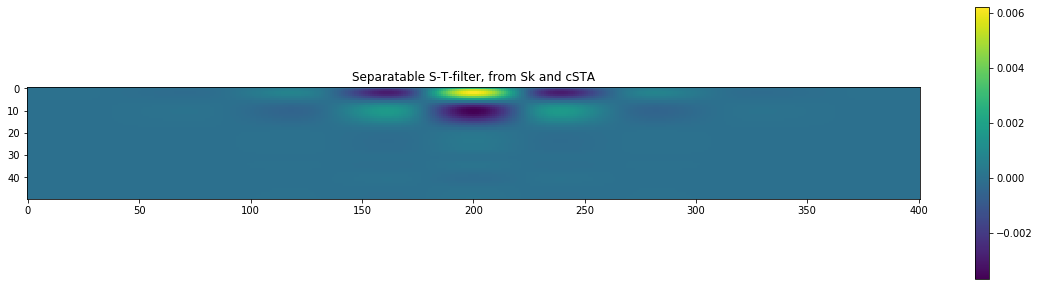

In [23]:
plt.imshow(ssSTk)
plt.colorbar()
plt.title('Separatable S-T-filter, '+'from Sk and cSTA')
fig = plt.gcf()
fig.set_size_inches(20, 5)

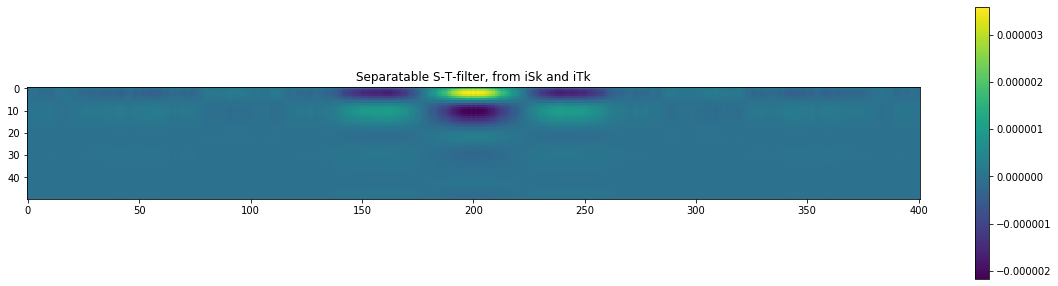

In [24]:
plt.imshow(sSTk)
plt.colorbar()
plt.title('Separatable S-T-filter, '+'from iSk and iTk')
fig = plt.gcf()
fig.set_size_inches(20, 5)

# Apply SVD on Spatial-Temporal Kernel

In [25]:
from numpy import linalg as la
U,sigma,VT=la.svd(ST_kernel)

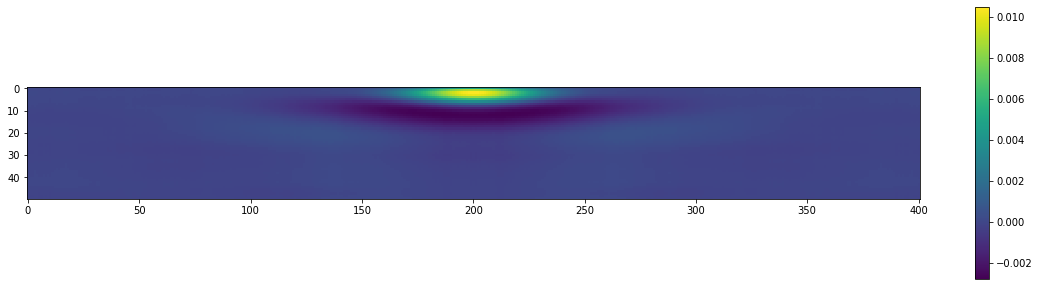

In [26]:
reSTK = np.zeros_like(ST_kernel)
for i in range(len(sigma)):
    reSTK += sigma[i]*np.matmul(U[:,i][:, np.newaxis], VT[i,:][np.newaxis, :])
plt.imshow(reSTK)
plt.colorbar()
fig = plt.gcf()
fig.set_size_inches(20, 5)

In [27]:
sigma/sum(sigma)

array([6.61949608e-01, 2.21913850e-01, 6.45639801e-02, 3.03357083e-02,
       9.55285986e-03, 6.35771263e-03, 2.04623967e-03, 9.25090125e-04,
       4.76198690e-04, 4.23372791e-04, 2.61432711e-04, 1.78352169e-04,
       1.54953387e-04, 1.25265471e-04, 9.85308693e-05, 6.68791491e-05,
       6.07589942e-05, 5.11502341e-05, 4.76253389e-05, 4.09243530e-05,
       3.77742052e-05, 2.86170503e-05, 2.66662241e-05, 2.15372281e-05,
       1.99912506e-05, 1.84428390e-05, 1.63051188e-05, 1.51298419e-05,
       1.39117895e-05, 1.36546900e-05, 1.28985775e-05, 1.19637123e-05,
       1.13786786e-05, 1.07999574e-05, 1.05162476e-05, 9.47822496e-06,
       8.38023461e-06, 8.25961972e-06, 7.86498889e-06, 7.72941396e-06,
       7.43024291e-06, 6.79044591e-06, 6.45980642e-06, 6.23895421e-06,
       5.95322581e-06, 5.64371613e-06, 5.28509578e-06, 4.98478168e-06,
       4.77497079e-06, 4.64555358e-06])

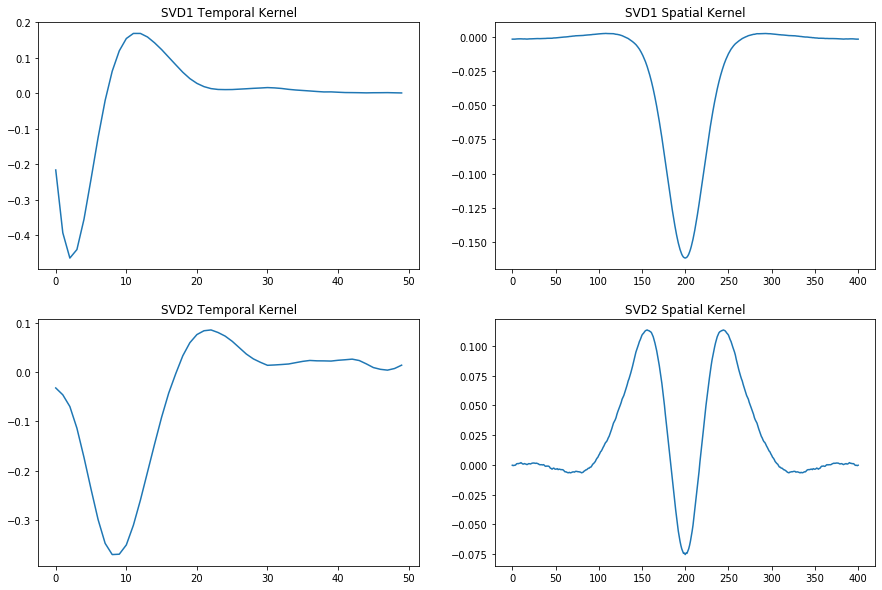

In [28]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=2, ncols=2)
ax2.plot(U[:,0])
ax2.set_title('SVD1 Temporal Kernel')
ax3.plot(VT[0,:])
ax3.set_title('SVD1 Spatial Kernel')
ax4.plot(U[:,1])
ax4.set_title('SVD2 Temporal Kernel')
ax5.plot(VT[1,:])
ax5.set_title('SVD2 Spatial Kernel')
fig.set_size_inches(15, 10)

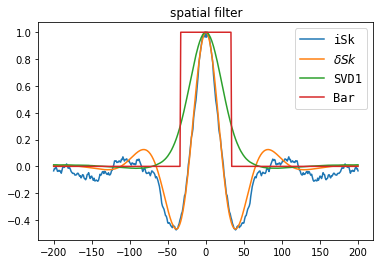

In [29]:
plt.plot(space_window, iSk/max(iSk), label = 'iSk')
cut_Delta_output = Delta_output[-1,int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1]
plt.plot(space_window, cut_Delta_output/max(cut_Delta_output), label = r'$\delta Sk$')
plt.plot(space_window, -VT[0,:]/max(-VT[0,:]), label = 'SVD1')
barsize = np.zeros_like(space_window);
barsize[np.arange(-round(hw/dx),(round(hw/dx)+1))++round(len(barsize)/2)] = 1
plt.plot(space_window, barsize, label = 'Bar')
plt.title('spatial filter')
plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

# plt.xlim([-30, 30])

In [1]:
from scipy.optimize import curve_fit
x = space_window.copy()
# y = -VT[0,:]/max(-VT[0,:])
y = Delta_output_y[-1,int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1]

# weighted arithmetic mean (corrected - check the section below)
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum((y-min(y)) * (x - mean)**2) / sum(y-min(y)))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def DoG(x, a1, x0, sigma1, a2, sigma2):
    return a1 * np.exp(-(x - x0)**2 / (2 * sigma1**2)) - a2 * np.exp(-(x - x0)**2 / (2 * sigma2**2))

# popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])
popt,pcov = curve_fit(DoG, x, y, p0=[max(y), 0, sigma, -0.1*max(y), 5*sigma])
print(popt)

plt.plot(x, y, 'b+:', label='data')
plt.plot(x, DoG(x, *popt), 'r-', label='fit')
plt.legend()
plt.title('Fig. 3 - Fit for Time Constant')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.show()

NameError: name 'space_window' is not defined

In [40]:
popt

array([ 9.94529542e-01, -2.72367825e-05,  2.17802447e+01, -7.64357872e-05,
        8.76314844e+04])

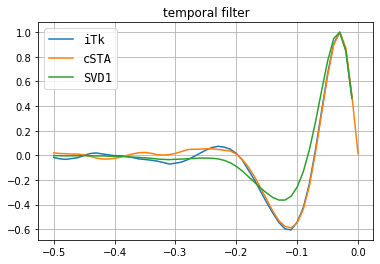

In [32]:
plt.plot(new_time_axis, iTk/max(iTk))
plt.plot(TKtaxis,n_TK)
plt.plot(new_time_axis, -U[:,0]/max(-U[:,0]))
plt.grid()

plt.title('temporal filter')

plt.legend( ('iTk', 'cSTA', 'SVD1'), loc='best', prop={'size': 'large', 'family': 'monospace'})

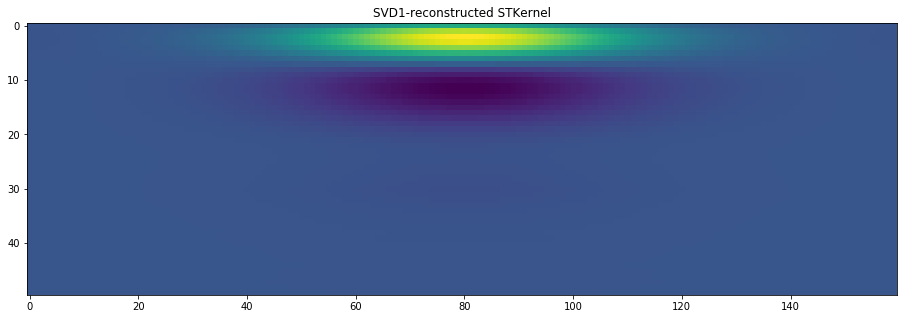

In [33]:
cSVD = 0
SVD_STkernel = np.matmul(U[:,cSVD][:, np.newaxis], VT[cSVD,:][np.newaxis, :])
plt.imshow(SVD_STkernel[:,int(ST_kernel.shape[1]*0.3):int(ST_kernel.shape[1]*0.7)])
plt.title('SVD'+str(cSVD+1)+'-reconstructed STKernel')
fig = plt.gcf()
fig.set_size_inches(20, 5)

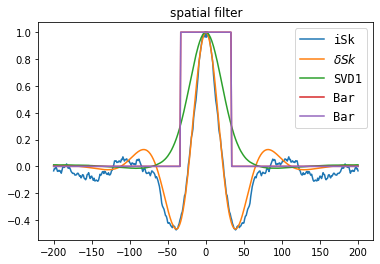

In [34]:
plt.plot(space_window, iSk/max(iSk), label = 'iSk')
cut_Delta_output = Delta_output[-1,int(xlen/dx/2)-int(xlen/dx/10):int(xlen/dx/2)+int(xlen/dx/10)+1]
plt.plot(space_window, cut_Delta_output/max(cut_Delta_output), label = r'$\delta Sk$')
plt.plot(space_window, -VT[0,:]/max(-VT[0,:]), label = 'SVD1')
barsize = np.zeros_like(space_window);
barsize[np.arange(-round(hw/dx),(round(hw/dx)+1))++round(len(barsize)/2)] = 1
plt.plot(space_window, barsize, label = 'Bar')


plt.plot(space_window, barsize, label = 'Bar')
plt.title('spatial filter')
plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})

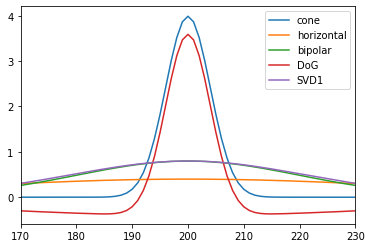

In [35]:
KC = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['C'])
KH = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['H'])
KB = Gaussian_filter_1d(space_window*dx,FBFF_sigma_dict['B'])
plt.plot(KC, label = 'cone')
plt.plot(KH, label = 'horizontal')
plt.plot(KB, label = 'bipolar')
plt.plot(KC-KH, label = 'DoG')
plt.plot(-VT[0,:]/max(-VT[0,:])*max(KB), label = 'SVD1')

plt.xlim([200-30, 200+30])
plt.legend()

In [36]:
FBFF_sigma_dict

{'H': 1, 'C': 0.1, 'tau_y': 0.02, 'B': 0.5}